##### Voreinstellung für Visualisierung

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import der erforderlichen Bibliotheken

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

# Laden der Daten

In [4]:
# Hilfsklasse Path zum Laden der Dateien
path = Path("data")

In [6]:
# Laden und Selektion der Daten
df = pd.read_csv(path/'metadata.csv')
df = df[['name','meta.clinical.benign_malignant']]
df = df.loc[(df['meta.clinical.benign_malignant'] != 'indeterminate') & (df['meta.clinical.benign_malignant'] != 'indeterminate/malignant')]

In [5]:
# Optional für Verkleinerung des Datensatzes zu Testzwecken
frac = 1
df = df.sample(frac = frac) 

In [6]:
# Anzahl der Bilder mit gutartigen Tumoren in % -> Default Genauigkeit beim Raten
default_acc = round(len(df[df['meta.clinical.benign_malignant'] == 'benign'])/len(df)*100,1)
default_acc

72.9

In [5]:
# Zur Reproduktion des Modells wird Random Seed gesetzt
np.random.seed(42)
# Batz Size Zuweisung
bs = 16
#bs = 64
# Wrapper Klasse ImageDataBunch zur Weiterverarbeitung
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=500, bs=bs).normalize(imagenet_stats)

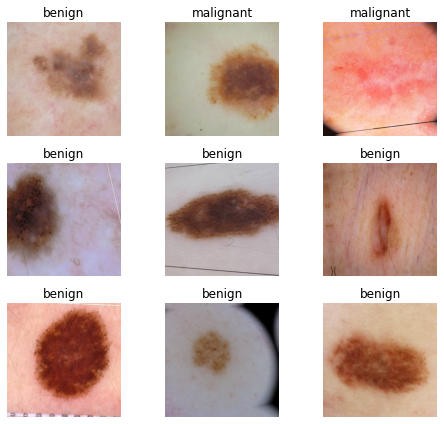

In [63]:
# Visualisierung einer Auswahl an Bildern
data.show_batch(rows=3, figsize=(7,6))

# ResNet-34

In [44]:
# Erzeugung des Learners ResNet-34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [45]:
# Training des Learners
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.172870,0.672209,0.336134,00:20
1,1.046767,0.664823,0.277311,00:20
2,0.933386,0.624773,0.243697,00:20
3,0.874751,0.504559,0.218487,00:19
4,0.784587,0.576126,0.226891,00:20
5,0.686961,0.551907,0.235294,00:19
6,0.613426,0.508582,0.210084,00:20
7,0.556466,0.485243,0.176471,00:19
8,0.483865,0.476862,0.184874,00:19
9,0.441384,0.482351,0.193277,00:20


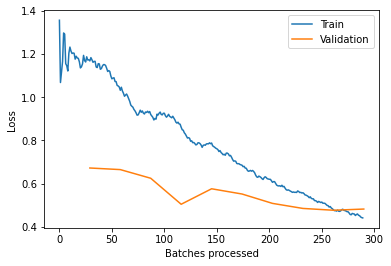

In [46]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [47]:
learn.save('stage1-resnet34')

In [48]:
# Learning Rate finden durch Methode lr_find()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


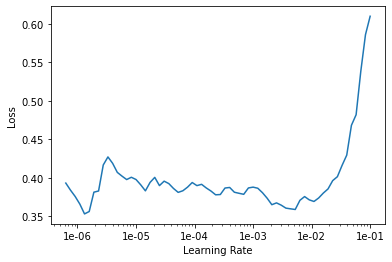

In [49]:
# Plotten des Learners
learn.recorder.plot()

In [50]:
# Vortrainiertes Model entsperren
learn.unfreeze()

In [51]:
learn.fit_one_cycle(10, max_lr=1e-06)

epoch,train_loss,valid_loss,error_rate,time
0,0.385039,0.481183,0.193277,00:26
1,0.404097,0.482961,0.193277,00:26
2,0.419357,0.466438,0.176471,00:26
3,0.408903,0.480052,0.184874,00:26
4,0.423010,0.470673,0.210084,00:26
5,0.423585,0.477253,0.184874,00:26
6,0.412150,0.481463,0.201681,00:26
7,0.438445,0.480924,0.193277,00:27
8,0.415448,0.467335,0.184874,00:26
9,0.413601,0.478643,0.201681,00:26


In [17]:
learn.save('stage2-500px-resnet34')

In [52]:
# Progressive Resizing: Von kleinen Bildern zu größeren Bildern. Dadurch generalsiert Modell besser.
# Vergrößerung der Bilder auf 700px
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=700, bs=bs).normalize(imagenet_stats)

In [53]:
# Zuweisung der neuen Daten
learn.data = data

In [55]:
# Einfrieren des Modells
learn.freeze()

In [56]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.463510,0.343327,0.151261,00:36
1,0.478183,0.311462,0.159664,00:36
2,0.494263,0.519403,0.226891,00:35
3,0.527017,0.367219,0.184874,00:36
4,0.500633,0.407725,0.184874,00:35
5,0.484910,0.431671,0.210084,00:36
6,0.455989,0.397507,0.184874,00:36
7,0.433785,0.383224,0.193277,00:35
8,0.398658,0.386873,0.168067,00:36
9,0.359202,0.361993,0.159664,00:36


Train_loss verläuft lange über dem Wert von Val_loss. Dies deutet auf Underfitting hin! Ergo sind weitere epochs sinnvoll.

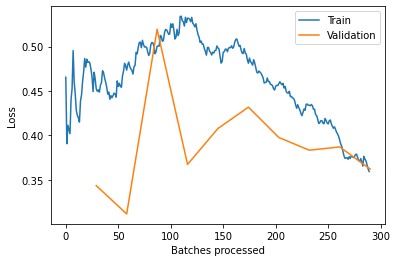

In [57]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [58]:
learn.save('stage3-700px-resnet34')

In [59]:
# Learning Rate finden durch Methode lr_find()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


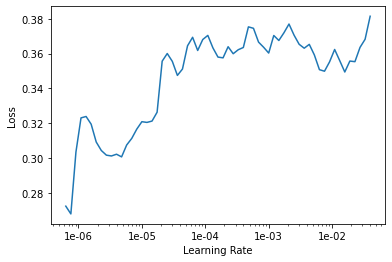

In [60]:
# Plotten des Learners
learn.recorder.plot()

In [61]:
# Vortrainiertes Model entsperren
learn.unfreeze()

In [62]:
learn.fit_one_cycle(10, max_lr=1.5e-06)

epoch,train_loss,valid_loss,error_rate,time
0,0.288282,0.372462,0.168067,00:49
1,0.323575,0.376782,0.168067,00:48
2,0.321218,0.357422,0.134454,00:47
3,0.324580,0.366565,0.151261,00:47
4,0.326816,0.369264,0.168067,00:47
5,0.317106,0.354821,0.159664,00:47
6,0.339041,0.364813,0.151261,00:48
7,0.319164,0.366566,0.151261,00:48
8,0.320743,0.360552,0.134454,00:48
9,0.322561,0.365619,0.176471,00:48


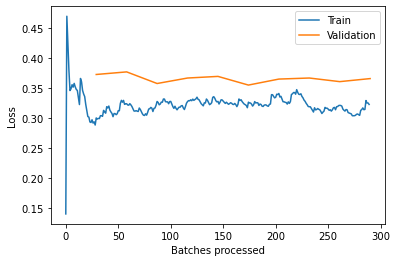

In [63]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [66]:
learn.save('stage4-700px-resnet34')

In [67]:
# Learning Rate finden durch Methode lr_find()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


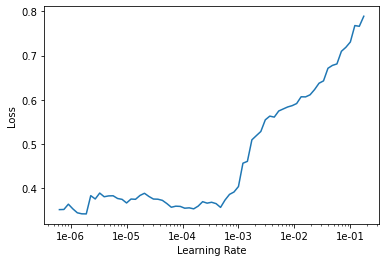

In [68]:
# Plotten des Learners
learn.recorder.plot()

Fazit: Aus Sicht der Learning Rate ein fein optimiertes NN.

# ResNet-34: Evaluation und Intepretation

In [64]:
# Interpretation der Klassifikation (Klasse)
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

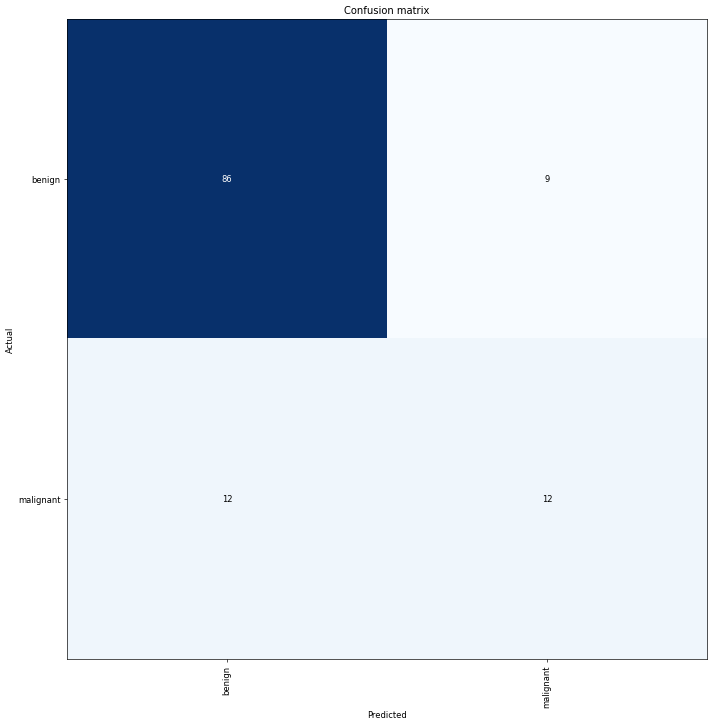

In [65]:
# Matrix zur Bewertungs des Klassifikators
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Sensitivität: 50%
Spezifität: 90,5%

# ResNet-50

In [69]:
# 125 px Bildgröße
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=125, bs=bs).normalize(imagenet_stats)

In [70]:
# Erzeugung des Learnes ResNet-50
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [71]:
# Training des Learners
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.403941,0.975652,0.344538,00:10
1,1.312248,1.120947,0.319328,00:07
2,1.112270,0.821427,0.302521,00:07
3,0.973195,0.654734,0.226891,00:07
4,0.795345,0.560108,0.226891,00:06
5,0.653350,0.543490,0.294118,00:06
6,0.564729,0.601799,0.268908,00:07
7,0.519635,0.600274,0.226891,00:06
8,0.463397,0.566170,0.218487,00:06
9,0.432021,0.559862,0.226891,00:07


In [72]:
learn.save('stage1-125px-resnet50')

In [76]:
# 250 px Bildgröße
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=250, bs=bs).normalize(imagenet_stats)

In [77]:
learn.data = data

In [78]:
# Training des Learners
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.543420,0.519448,0.226891,00:18
1,0.510029,0.581475,0.310924,00:12
2,0.521741,0.742496,0.327731,00:12
3,0.524483,0.747588,0.260504,00:12
4,0.471838,0.618400,0.210084,00:12
5,0.442826,0.607222,0.268908,00:13
6,0.389128,0.780769,0.252101,00:13
7,0.355744,0.669654,0.294118,00:13
8,0.319888,0.624900,0.268908,00:13
9,0.297455,0.613539,0.260504,00:13


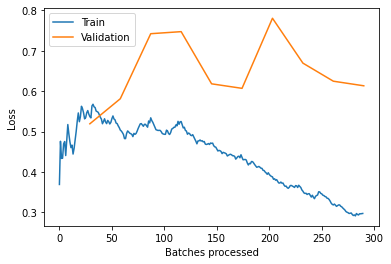

In [79]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [80]:
learn.save('stage2-250px-resnet50')

In [91]:
# 500 px Bildgröße
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=500, bs=bs).normalize(imagenet_stats)

In [92]:
learn.data = data

In [93]:
# Training des Learners
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.507805,0.450117,0.193277,00:38
1,0.464833,0.467509,0.210084,00:38
2,0.471699,0.609281,0.243697,00:38
3,0.469604,0.557088,0.302521,00:38
4,0.447759,0.637974,0.226891,00:38
5,0.433659,0.660554,0.218487,00:39
6,0.390321,0.622136,0.252101,00:38
7,0.353196,0.624370,0.260504,00:39
8,0.307703,0.666647,0.277311,00:38
9,0.275050,0.644247,0.252101,00:38


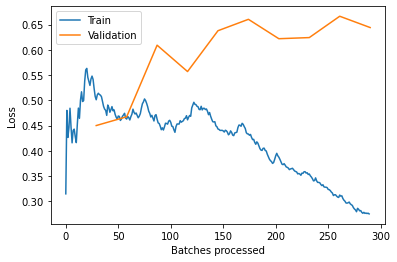

In [94]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

Validation Loss wird immer größer: Mögliches Overfitting?

In [95]:
learn.save('stage3-500px-resnet50')

# ResNet-50: Start bei 500px

In [6]:
# 500 px Bildgröße
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=500, bs=bs).normalize(imagenet_stats)

In [8]:
# Erzeugung des Learnes ResNet-50
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [9]:
# Training des Learners
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.330326,0.863177,0.344538,00:51
1,1.156297,1.555841,0.378151,00:39
2,1.028793,0.741837,0.277311,00:38
3,0.825722,0.628097,0.243697,00:39
4,0.688425,0.711437,0.285714,00:38
5,0.604971,0.696775,0.285714,00:39
6,0.537716,0.589945,0.252101,00:39
7,0.497929,0.649061,0.268908,00:38
8,0.438774,0.618725,0.268908,00:39
9,0.376656,0.607096,0.268908,00:39


In [10]:
learn.save('stage1-500px-resnet50')

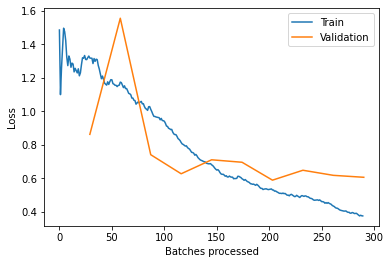

In [11]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [12]:
# Learning Rate finden durch Methode lr_find()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


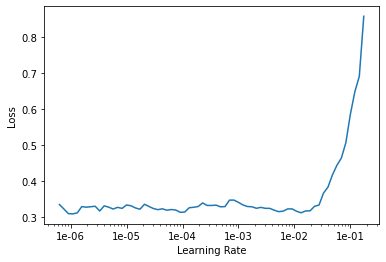

In [13]:
# Plotten des Learners
learn.recorder.plot()

In [9]:
# 500 px Bildgröße
bs = 8
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=500, bs=bs).normalize(imagenet_stats)

In [9]:
# Erzeugung des Learnes ResNet-50
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [11]:
# Training des Learners
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.305138,1.117135,0.352941,00:55
1,1.214092,0.801966,0.268908,00:39
2,1.004147,0.917604,0.277311,00:39
3,0.790083,0.614472,0.243697,00:39
4,0.736582,0.766751,0.310924,00:39
5,0.574498,0.724232,0.294118,00:39
6,0.516988,0.744629,0.302521,00:39
7,0.501642,0.557305,0.243697,00:40
8,0.449519,0.540892,0.260504,00:39
9,0.402149,0.521493,0.235294,00:39


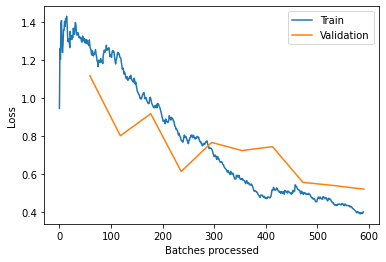

In [12]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [13]:
learn.save('stage1-500px-bs8-resnet50')

In [14]:
# Learning Rate finden durch Methode lr_find()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


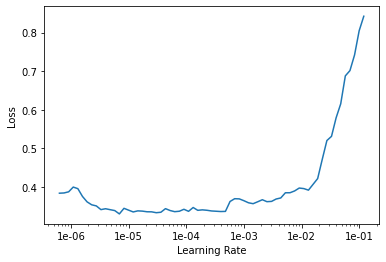

In [15]:
learn.recorder.plot()

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(10, max_lr=1.5e-06)

epoch,train_loss,valid_loss,error_rate,time
0,0.423016,0.538872,0.277311,00:56
1,0.443342,0.523403,0.252101,00:52
2,0.403772,0.522051,0.226891,00:52
3,0.440803,0.554143,0.277311,00:52
4,0.420436,0.503748,0.243697,00:52
5,0.371536,0.522631,0.252101,00:52
6,0.375306,0.501915,0.235294,00:52
7,0.379013,0.521234,0.243697,00:52
8,0.395373,0.510464,0.243697,00:52
9,0.408060,0.510423,0.226891,00:52


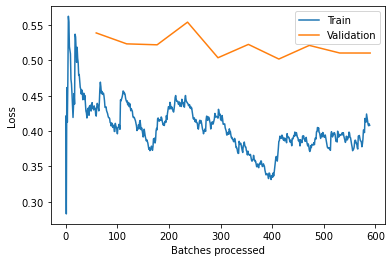

In [18]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [19]:
learn.save('stage2-500px-bs8-resnet50')

In [20]:
learn.freeze()

In [21]:
# Learning Rate finden durch Methode lr_find()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


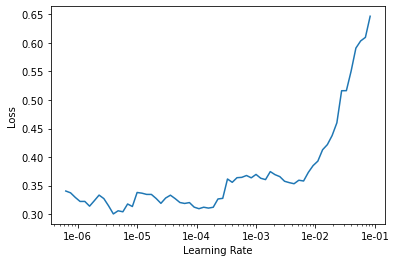

In [22]:
learn.recorder.plot()

In [8]:
# 750 px Bildgröße
bs = 8
data = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), suffix='.jpg', size=750, bs=bs).normalize(imagenet_stats)

In [24]:
# Training des Learners
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.403586,0.519347,0.277311,00:40
1,0.454913,0.598079,0.210084,00:39
2,0.579322,0.708283,0.302521,00:39
3,0.545824,0.656033,0.260504,00:39
4,0.569753,0.676785,0.252101,00:39
5,0.512452,0.589159,0.235294,00:39
6,0.432183,0.621889,0.268908,00:39
7,0.371738,0.642759,0.252101,00:40
8,0.334340,0.605339,0.268908,00:40
9,0.307560,0.612025,0.243697,00:40


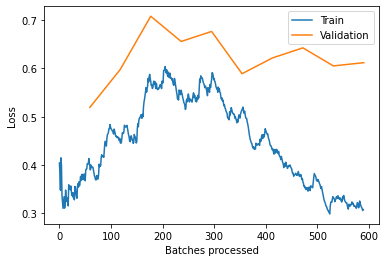

In [25]:
# Visualisierung des Train- und Validation Losses über Trainingszeit
learn.recorder.plot_losses()

In [26]:
learn.save('stage3-700px-bs8-resnet50')

# ResNet-50: Evaluation und Intepretation

In [11]:
# Interpretation der Klassifikation (Klasse)
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

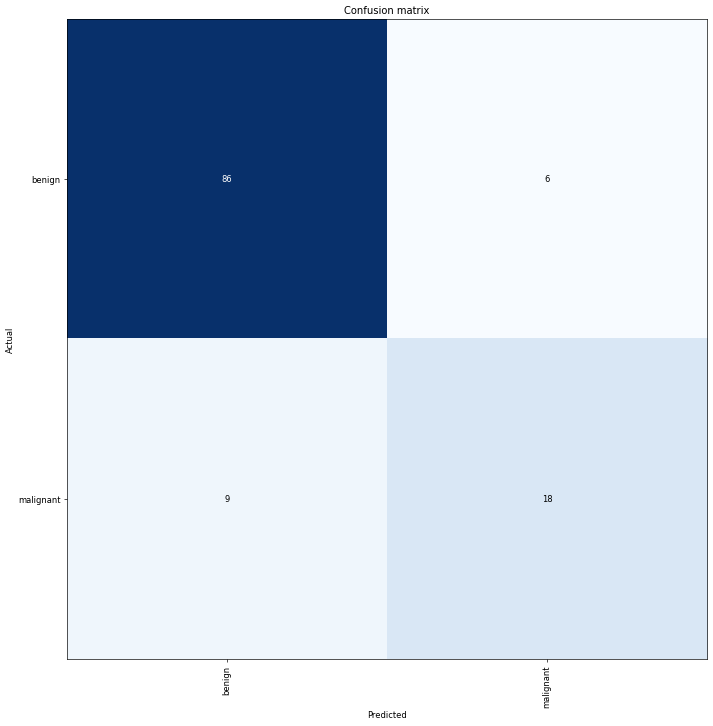

In [12]:
# Matrix zur Bewertungs des Klassifikators
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Sensitivität: 66,7%
Spezifität: 93,5%